In [2]:
# Set up session
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=QUmo90NF0IaAItrr0V7ubvv5m-gnml5tCjhS_18872Q&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmrj6R9ebBfGS0yerSuYz9G0xMMgq4iL5006bsPMpyf1Dc9gyEanKTZM

Successfully saved authorization token.


Open some dataset in Hispaniola


In [29]:
zoomed_out =  ee.Geometry.Polygon(
        [[[-74.60668900677238, 20.088333497505946],
          [-74.60668900677238, 17.687361057873034],
          [-68.11376908489738, 17.687361057873034],
          [-68.11376908489738, 20.088333497505946]]])
zoomed_in =  ee.Geometry.Polygon(
        [[[-71.7976970344606, 19.335441167371748],
          [-71.7976970344606, 19.19316176101097],
          [-71.60268971024185, 19.19316176101097],
          [-71.60268971024185, 19.335441167371748]]])
haiti_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Haiti'))

dr_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Dominican Republic'))


# to filter to Haiti/Congo:
# .filter(ee.Filter.eq('country_na', 'Haiti'))


collection = ee.ImageCollection('MODIS/006/MOD44B').filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)
veg2019 = collection.filterDate('2019-01-01', '2019-12-31').first()
veg2018 = collection.filterDate('2018-01-01', '2018-12-31').first()
veg2000 = collection.filterDate('2000-01-01', '2000-12-31').first()
veg2001 = collection.filterDate('2001-01-01', '2000-12-31').first()
veg2002 = collection.filterDate('2002-01-01', '2000-12-31').first()
veg2003 = collection.filterDate('2003-01-01', '2000-12-31').first()
veg2004 = collection.filterDate('2004-01-01', '2000-12-31').first()
veg2005 = collection.filterDate('2005-01-01', '2000-12-31').first()
veg2006 = collection.filterDate('2006-01-01', '2000-12-31').first()
veg2007 = collection.filterDate('2007-01-01', '2000-12-31').first()
veg2008 = collection.filterDate('2008-01-01', '2000-12-31').first()
veg2009 = collection.filterDate('2009-01-01', '2000-12-31').first()
veg2010 = collection.filterDate('200-01-01', '2000-12-31').first()


Put all of these on a map (reference)


In [24]:
import folium
!pip install geehydro
import geehydro

  Created wheel for geehydro: filename=geehydro-0.2.0-py2.py3-none-any.whl size=10114 sha256=8a2b80fe58c1546b078f556d21594e1409c8b2844a6a0dedcb28145d02d26fee
  Stored in directory: /root/.cache/pip/wheels/c5/07/67/5fa6e7271b46bbe0acafdc7105bbee27a39ab7132d251d822d
Successfully built geehydro


In [ ]:
# Use folium to visualize the imagery.
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(veg2000, {'gain':2},'2000')
map.addLayer(veg2019, {'gain':2}, '2019')
map.addLayer(veg2018, {'gain':2},'2018')
folium.LayerControl().add_to(map)
map

Plot cumulative differences in vegetation(ignore this bit because I abandoned the idea)




In [ ]:
collectionNonVeg = collection.filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False).select('Percent_NonVegetated')

Check that collection still contains data (ignore this bit because I abandoned the idea)



In [ ]:
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(collectionNonVeg.first(), {'gain':2},'nonVeg')
folium.LayerControl().add_to(map)
map

In [ ]:
mean = collectionNonVeg.mean()

def subtracting(image):
  return image.subtract(mean).set('system:time_start', image.get('system:time_start'))

series = collectionNonVeg.map(subtracting)
series_sum = series.sum()

map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(series_sum, {'gain':2},'Cumulative difference in non-vegetation')
folium.LayerControl().add_to(map)
map

TIME SERIES (and it works!)

In [30]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

# List of used image bands
band_list = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']

collection = ee.ImageCollection('MODIS/006/MOD44B').select(band_list)#.filterBounds(point)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)

count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point
info = collection.getRegion(geometry=zoomed_out, scale=20000).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
print(yData)

# Bryon's changes:
trees = yData[:,0] #tree cover
non_tree_veg = yData[:,1] #non-tree veg
non_veg = yData[:,2] #non-veg

# Reshape tree array into Pandas Dataframe
dfTC = pd.DataFrame(data=trees, columns=['Tree Cover (%)'])
dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
groupTC =dfTC.groupby(['time']).mean()
print(groupTC.head())


# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=non_tree_veg, columns=['Non-Tree Vegetation (%)'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
groupNT =dfNT.groupby(['time']).mean()
print(groupNT.head())

# Do same for non-vegetated
dfNV = pd.DataFrame(data=non_veg, columns=['Non-Vegetated (%)'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
groupNV =dfNV.groupby(['time']).mean()
print(groupNV.head())


Number of images in collection:  20

[['id', 'longitude', 'latitude', 'time', 'Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated'], ['2000_03_05', -71.77539120114976, 18.056137210802383, 952214400000, 16, 67, 18], ['2001_03_06', -71.77539120114976, 18.056137210802383, 983836800000, 12, 66, 24], ['2002_03_06', -71.77539120114976, 18.056137210802383, 1015372800000, 11, 69, 22], ['2003_03_06', -71.77539120114976, 18.056137210802383, 1046908800000, 16, 65, 20], ['2004_03_05', -71.77539120114976, 18.056137210802383, 1078444800000, 19, 67, 16], ['2005_03_06', -71.77539120114976, 18.056137210802383, 1110067200000, 21, 62, 19], ['2006_03_06', -71.77539120114976, 18.056137210802383, 1141603200000, 25, 54, 22], ['2007_03_06', -71.77539120114976, 18.056137210802383, 1173139200000, 30, 54, 18], ['2008_03_05', -71.77539120114976, 18.056137210802383, 1204675200000, 29, 53, 20], ['2009_03_06', -71.77539120114976, 18.056137210802383, 1236297600000, 24, 54, 23], ['2010_03_06', -7

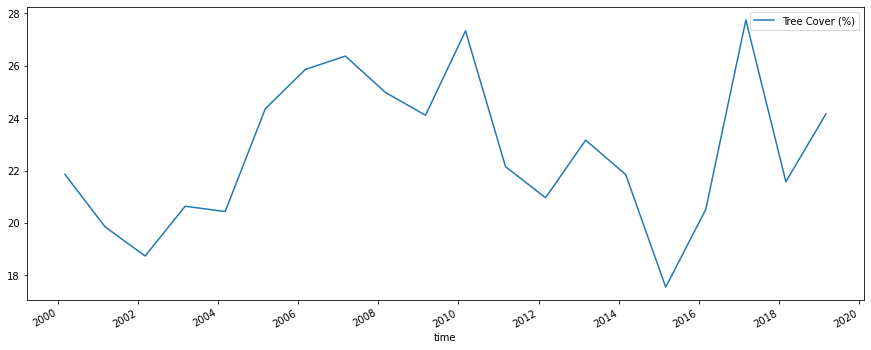

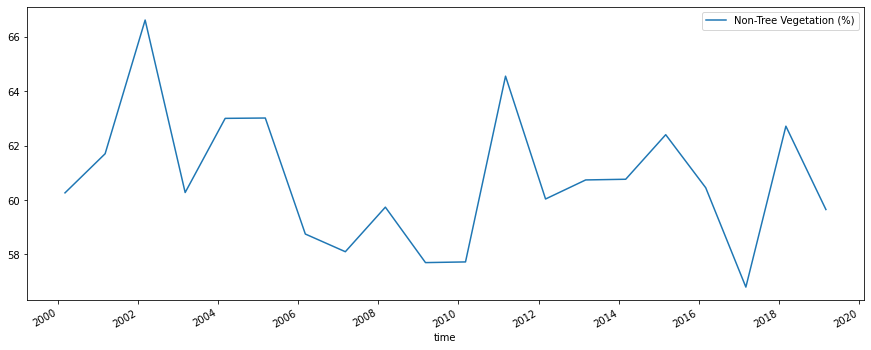

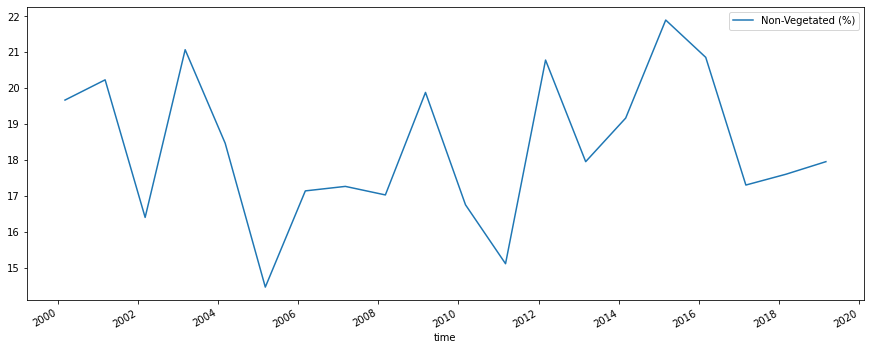

In [31]:
# Plotting

rcParams['figure.figsize'] = 15, 6
groupTC.plot()
groupNT.plot()
groupNV.plot()
plt.show()


Separate plots for Haiti and Congo


In [52]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

# List of used image bands
band_list = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']
# set scale to use in both
sc = 8000

# Haiti
collection = ee.ImageCollection('MODIS/006/MOD44B').select(band_list)
count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

info = collection.getRegion(haiti_region,scale = sc).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

trees = yData[:,0] + yData[:,1] # veg
non_tree_veg = yData[:,1] #non-tree veg
non_veg = yData[:,2] #non-veg

dfTC = pd.DataFrame(data=trees, columns=['Tree Cover (%)'])
dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
HaitiTC =dfTC.groupby(['time']).mean()
#print(groupTC.head())


# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=non_tree_veg, columns=['Non-Tree Vegetation (%)'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
HaitiNT =dfNT.groupby(['time']).mean()
#print(groupNT.head())

# Do same for non-vegetated
dfNV = pd.DataFrame(data=non_veg, columns=['Non-Vegetated (%)'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
HaitiNV =dfNV.groupby(['time']).mean()
#print(groupNV.head())




# Dominican Republic
info = collection.getRegion(dr_region,scale = sc).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

trees = yData[:,0] #tree cover
non_tree_veg = yData[:,1] #non-tree veg
non_veg = yData[:,2] #non-veg

dfTC = pd.DataFrame(data=trees, columns=['Tree Cover (%)'])
dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
DRTC =dfTC.groupby(['time']).mean()
#print(groupTC.head())


# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=non_tree_veg, columns=['Non-Tree Vegetation (%)'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
DRNT =dfNT.groupby(['time']).mean()
#print(groupNT.head())

# Do same for non-vegetated
dfNV = pd.DataFrame(data=non_veg, columns=['Non-Vegetated (%)'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
DRNV =dfNV.groupby(['time']).mean()

Number of images in collection:  20



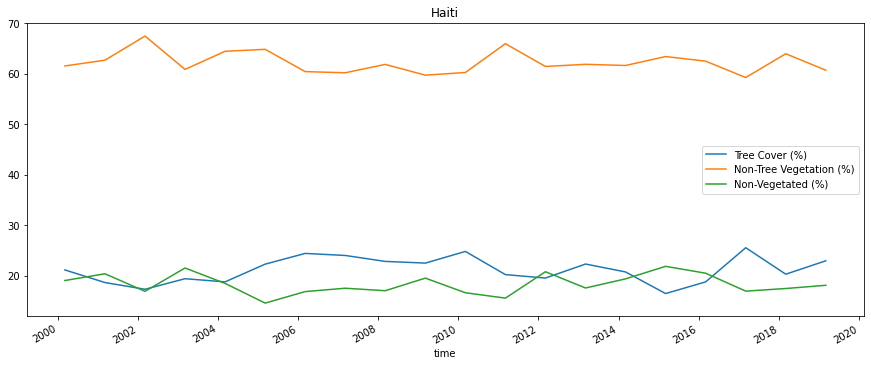

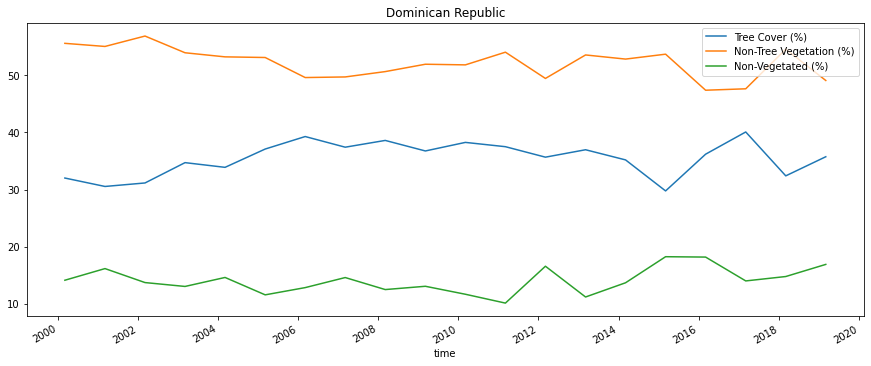

In [47]:
# plotting
rcParams['figure.figsize'] = 15, 6
fig1=HaitiTC.plot(title='Haiti')
HaitiNT.plot(ax=fig1)
HaitiNV.plot(ax=fig1)
plt.show()

fig2=DRTC.plot(title='Dominican Republic')
DRNT.plot(ax=fig2)
DRNV.plot(ax=fig2)
plt.show()

Visualise tree cover changes

In [53]:
collection = ee.ImageCollection('MODIS/006/MOD44B').filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False).filterBounds(zoomed_out)

